# Read Aurebesh

The goal of this notebook is to take an image that contains Aurebesh and translate it into basic (English). In order to do this, I used image processing techniques for Python from a few different libraries, namely OpenCV and scikit-image.

Preparing the image:

1. Load the image from a file
2. Convert the image to grayscale
3. Perform local thresholding on the image
4. Invert the binary image
5. Perform the morphological transformation of closing on the image
6. Find the contours of all the shapes in the image

Preparing the letters:

1. Extract the letters from the image
2. Perform closing on each letter to clean again
3. Find the contours of each letter again

---

- Cleaning Methods for Extracted Letters:
  - Closing
  - Make Border
- Identification Methods for Extracted Letters:
  - Corners
  - Contour
- Matching Methods for Extracted Letters:
  - Connected Component Analysis (CCA)
  - Canny Edges
  - Match Shapes

---

Goals:

- Get cleaner alphabet letters
  - Thresholding
  - Find new alphabet image (PNG file type)
- Identify letters with noncontiguous lines
  - CCA
  - Check distance between shapes where width > height
    - Euclidian Distance?
- Comine several methods of letter matching
  - Corners
  - Canny Edges
  - Region Props (CCA)
- ***Figure out the order in which the letters are extracted***

Done:

- ~~Remove all non-letter artifacts from images~~
  - ~~Region Props Area (CCA)~~

In [5]:
%matplotlib widget
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import ipympl
import imageio.v3 as iio
import skimage
from skimage.filters import threshold_local
import os
from PIL import Image as im

In [6]:
def create_plots(titles, images):
   plt.close()

   for i in range(len(images)):
      plt.subplot()
      plt.imshow(images[i])
      plt.title(titles[i])
      plt.axis('off')

   plt.show()

In [7]:
def create_plot(image):
   plt.close()
   
   fig, ax = plt.subplots()
   plt.imshow(image)
   plt.show()

## Load the Image from a File

The first step in the processs is loading the image from a file. I use the OpenCV function `imdread()` in order to accomplish this.

[OpenCV `imread()` documentation](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56)

In [8]:
def read_image(file_name):
   image = cv.imread(file_name)

   return image

## Convert the Image to Grayscale

Next, the image needs to be converted to grayscale if the original image loaded in the previous step was color (BGR: Blue, Green, Red). The OpenCV function `cvtColor()`, which takes two arguments, handles this task. This function converts an image from one color space to another, in our case from color to grayscale.

[OpenCV `cvtColor()` documentation](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)

In [9]:
def convert_to_grayscale(image):
   image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

   return image_gray

## Perform Local Thresholding on the Image

The `threshold_local()` function, which is part of the filters of skimage from scikit, takes a grayscale image, the block size or pixel neighborhood size, and the offset as arguments.

[scikit-image `threshold_local()` documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_local)

If the background of an image is fairly uniform, global thresholding usually does the trick. However, when the background of an image is messy, local thresholding tends to be more successful.

Local thresholding works by calculating thresholds in blocks surrounding each pixel. The threshold value that get applied is the result of the weighted mean of the local neighbors minus an offset value.

[scikit-image.org](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding_guide.html#sphx-glr-auto-examples-applications-plot-thresholding-guide-py)

In [12]:
# The recommended parameter values are 35 and 10 for block size and offset respectively.

def local_thresholding(image_gray, block_size=35, offset=10):
    local_thresh = threshold_local(image_gray, block_size, offset=offset)
    binary_local = image_gray > local_thresh

    return binary_local

## Invert the Binary Image

In order to find the contours, the image must be inverted so that the positive pixels represent the foreground instead of the background.

The scikit-image function `invert()` from the `util` module is handy for this purpose.

[scikit-image `invert()` documentation](https://scikit-image.org/docs/stable/api/skimage.util.html?highlight=util%20invert#skimage.util.invert)

In [13]:
def invert_image(image):
    inverted_image = skimage.util.invert(image)
    inverted_image = skimage.img_as_ubyte(inverted_image)

    return inverted_image

## Conduct a Closing Morphological Transformation

There are two main types of morphological transformation: erosion and dilation. These transformations conduct simple image-shape based operations, one which erodes away the boundaries of foreground objects and the other which increases the size of an object.

These two main operations can be combines to create variant operations such as closing and opening.

[docs.opencv.org](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

As a means of cleaning up the image a little bit, the morphological transformation of closing, which is dilation followed by erosion, can help make the edges of the letters appear more uniform. Closing is done with the OpenCV function `morphologyEx()` given the operation/op parameter is set to `MORPH_CLOSE`, which is one of several MorphTypes.

[OpenCV `morphologyEx()` documentation](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f)


In [14]:
def moprh_transform_closing(inverted_image):
    kernel = np.ones((3,3), np.uint8)
    image_closing = cv.morphologyEx(inverted_image, cv.MORPH_CLOSE, kernel)

    return image_closing

## Find the Contours of the Shapes in the Image

A contour is a curve that joins a series of continuous points along a boundary where the points have the same color and intensity.

[docs.opencv.org](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html)

### Locate the Contours

In [15]:
def find_contours(image_closing):
    contours, hierarchy = cv.findContours(image_closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    return contours, hierarchy

### Draw the Contours

In [16]:
def draw_contours(image_closing, contours):
    rgb_image = cv.cvtColor(image_closing, cv.COLOR_GRAY2RGB)
    image_contours = cv.drawContours(rgb_image, contours, -1, (0, 255, 0), 1)

    return image_contours, rgb_image

## Label Image Objects with Connected Component Analysis

The output of the closing morphological method is an ndarray of ndarrays with values of 0 or 255 depending on whether or not the pixel is black or white. What we need to do next is figure out how to identify objects within this list of lists.

In order to find the objects, we can use connnected component analysis (CCA), which takes a binary image as input, which we have (hence `binary_local`). CCA produces a new image integer values for each pixel where the values that are the same belong to the same object in the image.

(https://datacarpentry.org/image-processing/08-connected-components/index.html)

In [17]:
def connected_components(binary_image, connectivity=2):
    labeled_image, count = skimage.measure.label(binary_image, connectivity=connectivity, return_num=True)

    return labeled_image, count

What we know about CCA and Region Props is that we can access the centroid array (row, col) for each object.

## Extract the Letters from the Image

### Extract Letters with OpenCV and Contours

In [18]:
def extract_letters_opencv(contours, inverted_image, prefix):
   i = 0

   for cnt in contours:
      area = cv.contourArea(cnt)
      x, y, w, h = cv.boundingRect(cnt)
      roi = inverted_image[y:y + h, x:x + w]
      cv.imwrite(prefix + '-0' + str(i) + '.png', roi)
      i += 1

### Extract Letters with scikit-image and Connected Component Analysis (CCA)

In [19]:
def extract_letters_skimage(label_image, prefix):
   region_props = skimage.measure.regionprops(label_image)

   i = 0
   for prop in region_props:
      data = im.fromarray(region_props[i].image)
      data.save(prefix + '-0' + str(i) + '.png')
      i += 1

### Extract Letters with scikit-image and CCA by Area

In [31]:
def calc_min_area(region_props):
    region_tuples = []

    # Get the region props area and label for each object
    i = 0
    for obj in region_props:
        area = region_props[i].area
        label = region_props[i].label
        region_tuples.append([label, area])
        i += 1

    # Make a list of only the region prop areas
    region_areas = []
    for tuple in region_tuples:
        region_areas.append(tuple[1])

    # Calculate the cutoff point for object areas
    cutoff = (np.quantile(region_areas, .50) + np.mean(region_areas) / 2)

    return cutoff

In [30]:
def extract_letter_by_area(region_props):
    cutoff = calc_min_area(region_props)

    os.chdir('./extracted/')
    i = 0
    for prop in region_props:
        if region_props[i].area > cutoff:
            data = im.fromarray(region_props[i].image)
            label = region_props[i].label
            data.save('extracted' + '-0' + str(label) + '.png')
        i += 1
    os.chdir('..')

## Clean the Extracted Letters

Repeat the closing morphological transformation on the individual letter now that it's isolated.

In [29]:
def clean_extracted(extracted_letter):
   letter_closing = moprh_transform_closing(extracted_letter)

   return letter_closing

## Match the Extracted Letters to the Alphabet

(https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gaadc90cb16e2362c9bd6e7363e6e4c317)

### Shape Match on Individual Letters

In [28]:
def match_letters(extracted_letters, alphabet):
   res_list = []
   for e_letter in extracted_letters:
      print(e_letter)
      extracted = read_image(e_letter)
      e_contours, e_hierarhcy = find_contours(extracted)
      
      for a_letter in alphabet:
         print(a_letter)
         letter = read_image(a_letter)
         a_contours, a_hierarchy = find_contours(letter)

         result = cv.matchShapes(e_contours, a_contours, cv.CONTOURS_MATCH_I3, 0)
         if result < 0.01:
            res_list.append([e_contours, a_contours, result])
   
   return res_list

### Shape Match from Full Images

In [24]:
def match_letters2(memorial_contours, alpha_contours):
   res_list = []
   for cnt in memorial_contours:
      for letter in alpha_contours:
         result = cv.matchShapes(cnt, letter, 1, 0)
         if result < 0.1:
            res_list.append([cnt, letter, result])

   return res_list

# Run the Code

## Get the Aurebesh Alphabet

In [25]:
def get_aurebesh_alphabet():
    alphabet_image = read_image('aurebesh.jpg')
    alpha_gray = convert_to_grayscale(alphabet_image)
    alpha_binary = local_thresholding(alpha_gray, 35, 10)
    alpha_inverted = invert_image(alpha_binary)
    alpha_contours, alpha_hierarchy = find_contours(alpha_inverted)
    extract_letters_opencv(alpha_contours, alpha_inverted)
    alphabet = os.listdir('./alphabet')

    return alphabet

## Get the Letters from the Image

In [26]:
def get_letters_from_image():
    memorial_image = read_image('memorial.jpg')
    memorial_gray = convert_to_grayscale(memorial_image)
    memorial_binary = local_thresholding(memorial_gray)
    memorial_inverted = invert_image(memorial_binary)
    memorial_closing = moprh_transform_closing(memorial_inverted)
    memorial_contours, memorial_hierarchy = find_contours(memorial_closing)

    os.chdir('./extracted/')
    extract_letters_opencv(memorial_contours, memorial_inverted, 'extracted')
    os.chdir('..')

    extracted = os.listdir('./extracted')

    for f_name in extracted:
        index = extracted.index(f_name)
        extracted[index] = './extracted/' + f_name

    return extracted

In [608]:
# extracted_closing = []

# for f_name in extracted_letters:
#     extd_image = read_image(f_name)
#     extd_closing = clean_extracted(extd_image)
#     extracted_closing.append(extd_closing)

In [609]:
# i = 205

# print(extracted_letters[i])

# image = cv.imread(extracted_letters[i], 0)
# image_closing = cv.cvtColor(extracted_closing[i], cv.COLOR_BGR2GRAY)

# extd_contours, extd_hierarchy = find_contours(image)
# extd_contours_closing, extd_hierarchy_closing = find_contours(image_closing)

# extd_cnt = draw_contours(image, extd_contours)
# extd_cnt_closing = draw_contours(image_closing, extd_contours_closing)

In [593]:
def locate_corners(file_name):
    image_gray = cv.imread(file_name, 0)
    image_closing = moprh_transform_closing(image_gray)
    border = 5
    image_border = cv.copyMakeBorder(image_closing, border, border, border, border, cv.BORDER_CONSTANT)
    image_border_color = cv.cvtColor(image_border, cv.COLOR_GRAY2BGR)

    corners = cv.goodFeaturesToTrack(image_border, 50, 0.2, 0)
    corners = np.int0(corners)

    for i in corners:
        x, y = i.ravel()
        cv.circle(image_border_color, (x, y), 1, (0, 255, 0), 1)

    return image_border_color, corners

In [ ]:
letter1 = cv.imread('./alphabet/letter1.png', 0)

letter1_closing = moprh_transform_closing(letter1)

# Create a 5px border around the image so we can see all the edges
letter1_border = cv.copyMakeBorder(letter1_closing, 5, 5, 5, 5, cv.BORDER_CONSTANT)

letter1_border_color = cv.cvtColor(letter1_border, cv.COLOR_GRAY2BGR)

# Find the corners of the shape
corners = cv.goodFeaturesToTrack(letter1_border, 50, 0.2, 0)
corners = np.int0(corners)
  
plt.close()
# we iterate through each corner, 
# making a circle at each point that we think is a corner.
for i in corners:
    x, y = i.ravel()
    cv.circle(letter1_border_color, (x, y), 1, (0, 255, 0), 1)

plt.imshow(letter1_border_color)
plt.show()

In [599]:
extd_corner_image, extd_corners = locate_corners('./extracted/extracted-076.png')

In [ ]:
match_result = cv.matchShapes()

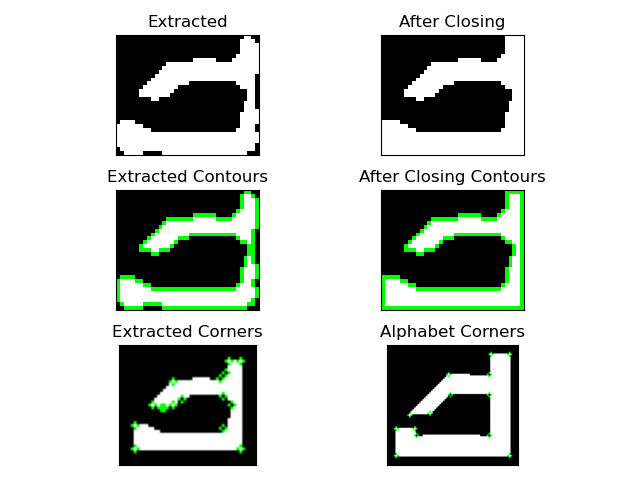

In [602]:
plt.close()

# Get the plots ready to go
fig, ax = plt.subplots(nrows=3, ncols=2)

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Extracted')

ax[0, 1].imshow(image_closing, cmap='gray')
ax[0, 1].set_title('After Closing')

ax[1, 0].imshow(extd_cnt[0])
ax[1, 0].set_title('Extracted Contours')

ax[1, 1].imshow(extd_cnt_closing[0])
ax[1, 1].set_title('After Closing Contours')

ax[2, 0].imshow(extd_corner_image)
ax[2, 0].set_title('Extracted Corners')

ax[2, 1].imshow(letter1_border_color)
ax[2, 1].set_title('Alphabet Corners')

for a in ax.ravel():
    a.tick_params(left = False, bottom = False, labelleft = False , labelbottom = False)

# Show the plots
plt.tight_layout()
plt.show()

## Match the Alphabet and the Extracted Letters

In [27]:
match_letters(extracted_letters, alphabet)

NameError: name 'extracted_letters' is not defined

In [159]:
res_list = match_letters2(memorial_contours, alpha_contours)

In [ ]:
i=2

memorial_letter = draw_contours(memorial_closing, res_list[i][0])
alpha_letter = draw_contours(alpha_inverted, res_list[i][1])
print(res_list[i][2])

plt.close()
# Get the plots ready to go
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(memorial_letter[0])
ax[0].set_title('Memorial')

ax[1].imshow(alpha_letter[0])
ax[1].set_title('Alphabet')

# Show the plots
plt.tight_layout()
plt.show()

# TESTING ONE TWO THREE

In [32]:
memorial_image = read_image('memorial.jpg')
memorial_gray = convert_to_grayscale(memorial_image)
memorial_binary = local_thresholding(memorial_gray)
memorial_inverted = invert_image(memorial_binary)
memorial_closing = moprh_transform_closing(memorial_inverted)

In [33]:
memorial_labeled, memorial_count = connected_components(memorial_closing, 2)

In [34]:
print(memorial_count)

231


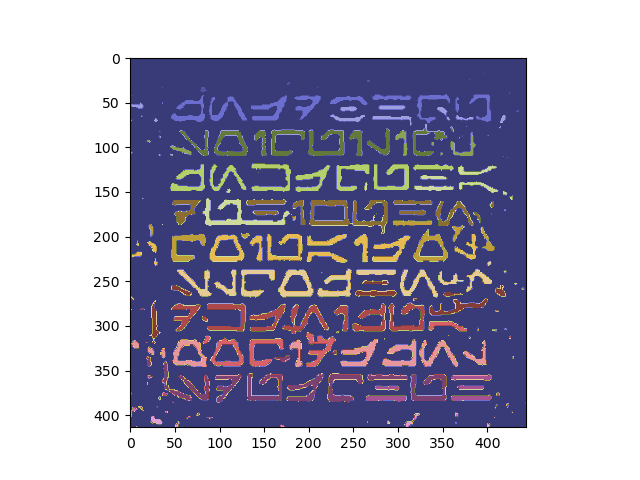

In [36]:
plt.close('all')

fig, ax = plt.subplots()
plt.imshow(memorial_labeled, cmap='tab20b')

In [37]:
memorial_regionprops = skimage.measure.regionprops(memorial_labeled)

In [40]:
centroid_list = []
x = []
y = []
z = []

i = 0
for object in memorial_regionprops:
    centroid_list.append(list(memorial_regionprops[i].centroid))
    x.append(memorial_regionprops[i].centroid[0])
    y.append(memorial_regionprops[i].centroid[1])
    z.append(memorial_regionprops[i].label)
    i += 1

In [41]:
print(centroid_list)

[[0.14285714285714285, 58.285714285714285], [1.6818181818181819, 306.6060606060606], [2.0, 342.5], [8.086206896551724, 329.37931034482756], [5.0, 285.5], [9.19047619047619, 381.9047619047619], [10.222222222222221, 122.33333333333333], [11.653846153846153, 221.46153846153845], [15.951612903225806, 353.0], [14.0, 377.0], [16.0, 19.0], [17.166666666666668, 394.6666666666667], [19.75, 336.0], [20.0, 30.0], [24.666666666666668, 379.3333333333333], [26.363636363636363, 266.54545454545456], [29.583333333333332, 176.41666666666666], [31.5, 408.5], [32.0, 100.0], [34.0, 35.5], [36.10344827586207, 81.24137931034483], [34.0, 209.5], [39.5, 424.0], [52.678260869565214, 334.9130434782609], [43.0, 0.25], [60.80909090909091, 67.12272727272727], [58.625, 156.39655172413794], [44.865979381443296, 291.7886597938144], [55.384905660377356, 395.17735849056606], [52.690625, 198.078125], [58.71989528795812, 107.09162303664921], [47.728205128205126, 244.15897435897435], [53.31372549019608, 365.37254901960785]

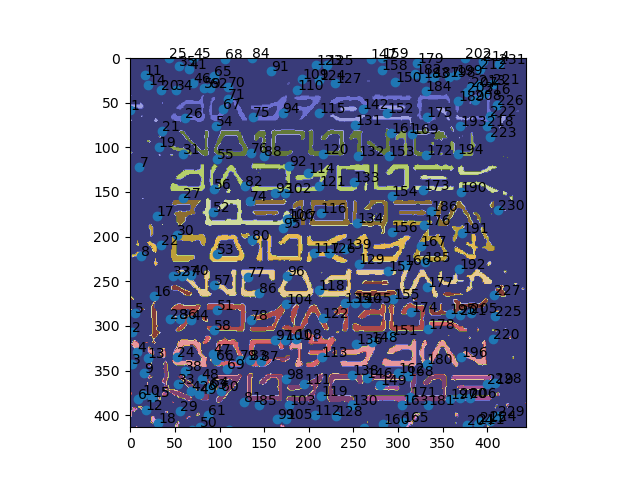

In [42]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(z):
    ax.annotate(txt, (x[i], y[i]))

plt.imshow(memorial_labeled, cmap='tab20b')
plt.show()

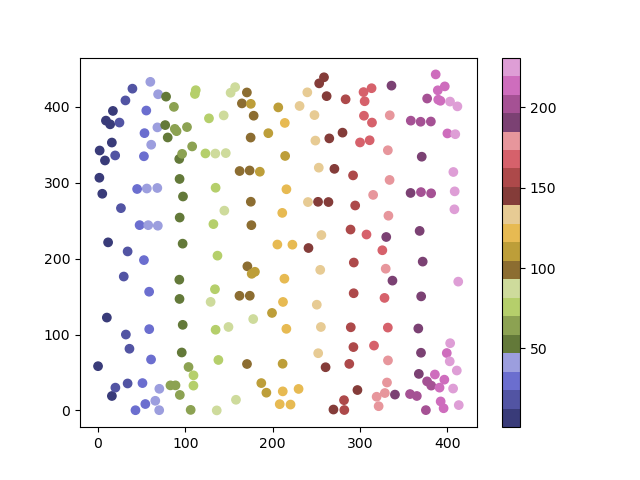

In [43]:
plt.close()
points = plt.scatter(x, y, c=z, cmap='tab20b')
plt.colorbar(points)
plt.show()